# Testing the neural network

In [1]:
%matplotlib inline
import sys
sys.path.append('../2_compare_detectors')
sys.path.append('../2_compare_detectors/bhtsne-master')
from image_scatter import *

import os
import numpy as np
import tensorflow as tf
import cv2
import pudb
import datetime
import time
import fnmatch
import random

import imgaug as ia
from imgaug import augmenters as iaa

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import misc

**Load all the cached data**

In [2]:
hists_test = np.load("hists_test.npy")
labels_test = np.load("labels_test.npy")
# hists_test = (hists_test / 255.) - 0.5
hists_train = np.load("hists_train.npy")
hists_train = (hists_train / 255.) - 0.5
labels_train = np.load("labels_train.npy")

In [ ]:
# print labels_train[0:5]
# print labels_test[0:5]
print hists_train[0:5]
# print hists_train[0:5]

**Design of the network**

Make placeholder values for all the variables (weights and biases)

In [3]:
# Design of network:
K = 36 # Conv layer, 3x3 patches, 1x1 stride
L = 72 # Conv layer, 3x3 patches, 2x2 stride
M = 144 # Conv layer, 3x3 patches, 2x2 stride
N = 288 # Conv layer, 3x3 layer, 2x2 stride 
O = 500 # Fully connected layer
P = 500 # Fully connected layer
# Softmax activation layer (n=2)

# We use Xavier-like weight initialization (2/number_of_inputs)
# http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
W1 = tf.Variable(tf.truncated_normal([3, 3, 3, K], stddev=2./(3*3*3)))
B1 = tf.Variable(tf.zeros([K]))
W2 = tf.Variable(tf.truncated_normal([3, 3, K, L], stddev=2./(3*3*3)))
B2 = tf.Variable(tf.zeros([L]))
W3 = tf.Variable(tf.truncated_normal([3, 3, L, M], stddev=2./(3*3*3)))
B3 = tf.Variable(tf.zeros([M]))
W4 = tf.Variable(tf.truncated_normal([3, 3, M, N], stddev=2./(3*3*3)))
B4 = tf.Variable(tf.zeros([N]))
W5 = tf.Variable(tf.truncated_normal([8 * 8 * N, O], stddev=2./(8*8*N)))
B5 = tf.Variable(tf.zeros([O]))
W6 = tf.Variable(tf.truncated_normal([O, P], stddev=2./O))
B6 = tf.Variable(tf.zeros([P]))
W7 = tf.Variable(tf.truncated_normal([P, 2], stddev=2./P))
B7 = tf.Variable(tf.zeros([2]))

# Input placeholder
X = tf.placeholder(tf.float32, [None, 64, 64, 3])

# Placeholder value for the ground truth label of the network
Y_ = tf.placeholder(tf.float32, [None, 2])

**Batch Normalization**

We will use batch normalization, define the function. We will use the moving average that was trained on the training set to normalize the test data

In [4]:
# test flag for batch norm
tst = tf.placeholder(tf.bool)
tst_conv = tf.placeholder(tf.bool)
iter = tf.placeholder(tf.int32)

# function from Martin Gorner (https://github.com/martin-gorner/tensorflow-mnist-
# tutorial/blob/master/mnist_4.2_batchnorm_convolutional.py#L53)
def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration)
    # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_averages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_averages

**Putting all the calculation of the model together**

In [5]:
Y1l = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
Y1bn, _ = batchnorm(Y1l, tst_conv, iter, B1, convolutional=True)
Y1 = tf.nn.relu(Y1bn)

Y2l = tf.nn.conv2d(Y1, W2, strides=[1, 2, 2, 1], padding='SAME')
Y2bn, _ = batchnorm(Y2l, tst_conv, iter, B2, convolutional=True)
Y2 = tf.nn.relu(Y2bn)

Y3l = tf.nn.conv2d(Y2, W3, strides=[1, 2, 2, 1], padding='SAME')
Y3bn, _ = batchnorm(Y3l, tst_conv, iter, B3, convolutional=True)
Y3 = tf.nn.relu(Y3bn)

Y4l = tf.nn.conv2d(Y3, W4, strides=[1, 2, 2, 1], padding='SAME')
Y4bn, _ = batchnorm(Y4l, tst_conv, iter, B4, convolutional=True)
Y4 = tf.nn.relu(Y4bn)

YY = tf.reshape(Y4, shape=[-1, 8*8*N])

Y5l = tf.matmul(YY, W5)
Y5bn, _ = batchnorm(Y5l, tst, iter, B5)
Y5r = tf.nn.relu(Y5bn)
Y5 = tf.nn.dropout(Y5r, 1.0)

Y6l = tf.matmul(Y5, W6)
Y6bn, _ = batchnorm(Y6l, tst, iter, B6)
Y6r = tf.nn.relu(Y6bn)
Y6 = tf.nn.dropout(Y6r, 1.0)

Y = tf.nn.softmax(tf.matmul(Y6, W7) + B7)

**Define loss function**

We weight the loss function here, since we use the prediction of the image *not* showing cream here (second column) the weight multiplyer will value a false positive strongly. The loss function is currently not used in this notebook.

In [6]:
cross_entropy = tf.reduce_mean(
    tf.nn.weighted_cross_entropy_with_logits(
        targets=Y_[:,1], logits=Y[:,1], pos_weight=3))

In [7]:
config = tf.ConfigProto(device_count = {'GPU': 0}) # Use the CPU for this notebook
init = tf.global_variables_initializer()
sess = tf.Session(config=config)
sess.run(init)

---
**Load pretrained model**

In [84]:
# after 765 epochs with 0.0005, logfile: conv Mon 17:21:49
model_name = "./models/big_conv_overnight_epoch_765.ckpt" 


# Mean accuracy of epoch (547): 0.915809
# Mean entropy of epoch  (547): 0.882813
# Test sensitivity: 0.802125502014
# Test specifitity: 0.9613453767
# Test positive predictive value: 0.953670271037
# Test accuracy of epoch (547): 0.882056
# Best model saved in file: ./models/big_conv_overnight_18_11_epoch2_best_546.ckpt

# model_name = "./models/big_conv_overnight_18_11_epoch_485.ckpt"
# model_name = "./models/big_conv_overnight_18_11_epoch2_best_546.ckpt"

######################################################################################
# Mean accuracy of epoch (1035): 0.919853
# Mean entropy of epoch  (1035): 0.879747
# Test sensitivity: 0.786437242984
# Test specifitity: 0.978915657736
# Test positive predictive value: 0.973684204426
# Test accuracy of epoch (1035): 0.883065
#model_name = "./models/big_conv_overnight_18_11_epoch2_best_1034.ckpt"
######################################################################################
saver = tf.train.Saver()
saver.restore(sess, model_name)

INFO:tensorflow:Restoring parameters from ./models/big_conv_overnight_epoch_765.ckpt


In [85]:
# Run on the test in batches, the network is so large that there is not enough
# memory for all the test data at once
batch_size = 32

pred_labels = []
number_of_runs = np.ceil(len(hists_test) / batch_size) + 1
test_accuracies = []
for i in range(number_of_runs.astype(int)):
    batch_begin = int(i*batch_size)
    batch_end = int(np.min((i*batch_size+batch_size, len(hists_test))))

    batch_X = hists_test[batch_begin:batch_end]

    test_pred = sess.run([Y], feed_dict={X: batch_X, tst: True, iter: i, tst_conv: True})

    pred_labels += test_pred

pred_labels = np.concatenate(pred_labels)

In [86]:
print pred_labels[0:10]

[[  9.98572707e-01   1.42733613e-03]
 [  9.99907374e-01   9.26397843e-05]
 [  9.96396482e-01   3.60359158e-03]
 [  3.20446165e-03   9.96795595e-01]
 [  1.64307944e-12   1.00000000e+00]
 [  9.99999523e-01   4.85746000e-07]
 [  9.99999523e-01   4.73634714e-07]
 [  9.99971628e-01   2.83654008e-05]
 [  9.65038538e-01   3.49615142e-02]
 [  2.29679141e-02   9.77032065e-01]]


---
**Calculate statistics**

In [87]:
pred_pos = (np.argmax(pred_labels, axis=1)==0)
pred_neg = (np.argmax(pred_labels, axis=1)==1)

truth_pos = (labels_test[:,0]==1)
truth_neg = (labels_test[:,0]==0)

true_pos = np.intersect1d(np.where(pred_pos), np.where(truth_pos))
true_neg = np.intersect1d(np.where(pred_neg), np.where(truth_neg))
false_pos = np.intersect1d(np.where(pred_pos), np.where(truth_neg))
false_neg = np.intersect1d(np.where(pred_neg), np.where(truth_pos))

sens = len(true_pos) / float(len(true_pos) + len(false_neg) + 0.00001)
spec = len(true_neg) / float(len(true_neg) + len(false_pos) + 0.00001)
ppv = len(true_pos) / float(len(true_pos) + len(false_pos) + 0.00001)
npv = len(true_neg) / float(len(true_neg) + len(false_neg) + 0.00001)

In [88]:
print "Number of false pos: " + str(len(false_pos))
print "Number of false neg: " + str(len(false_neg))

print "Test sensitivity: " + str(sens)
print "Test specifitity: " + str(spec)
print "Test positive predictive value: " + str(ppv)

Number of false pos: 123
Number of false neg: 350
Test sensitivity: 0.824208936091
Test specifitity: 0.961598498403
Test positive predictive value: 0.93027210357


**False positive images**

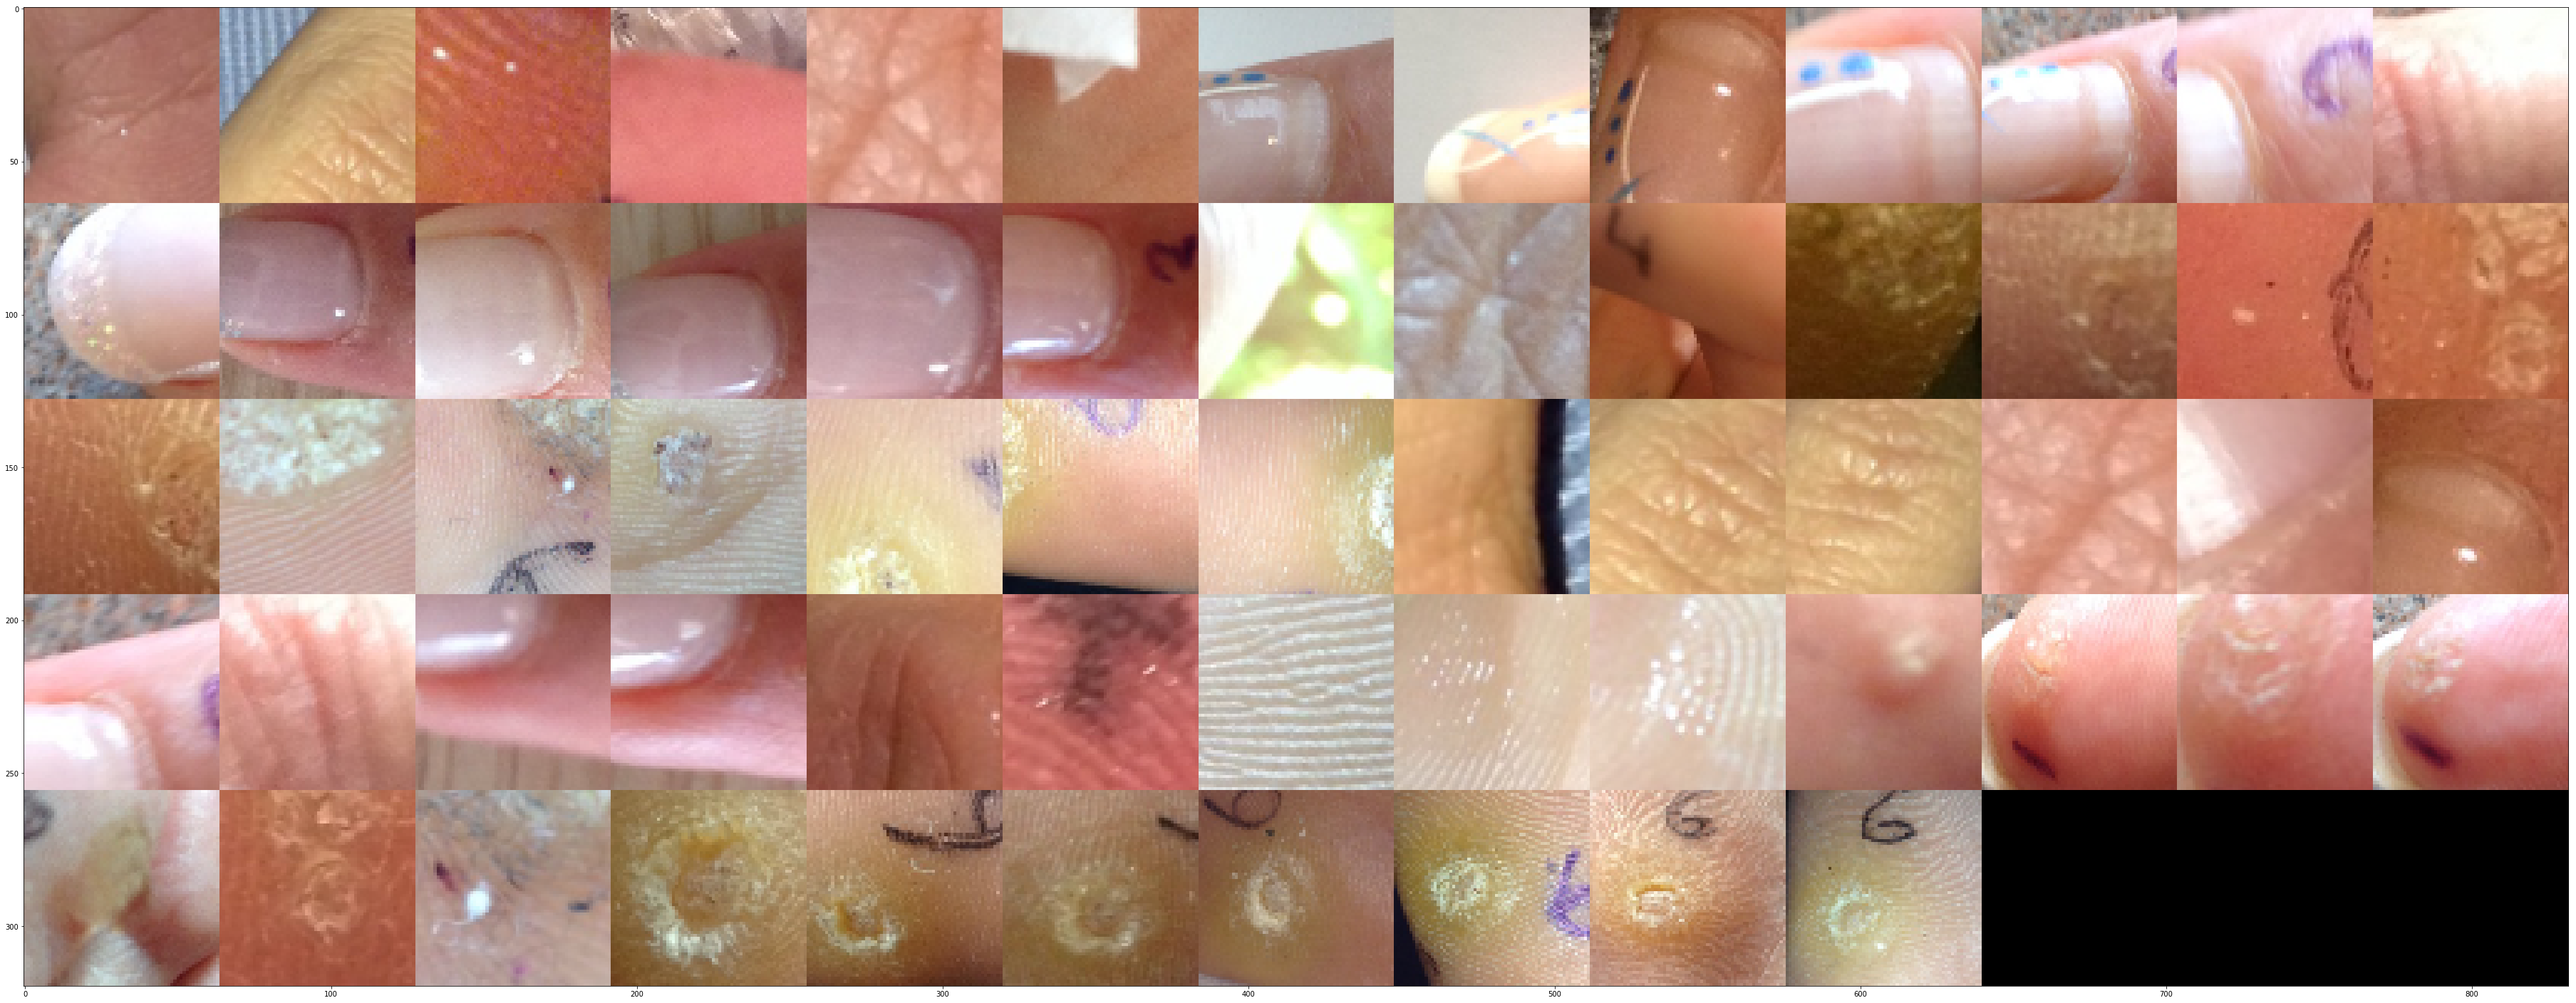

In [14]:
fig = plt.figure(figsize=(64, 64))  # width, height in inches
tstimages = (hists_test[false_pos] + 0.5) * 255.0
for i in range(len(false_pos)):
    tstimages[i] = cv2.cvtColor(tstimages[i].astype(np.float32), cv2.COLOR_BGR2RGB)
plt.imshow(ia.draw_grid(tstimages, cols=13, rows=5))

**False negative images**

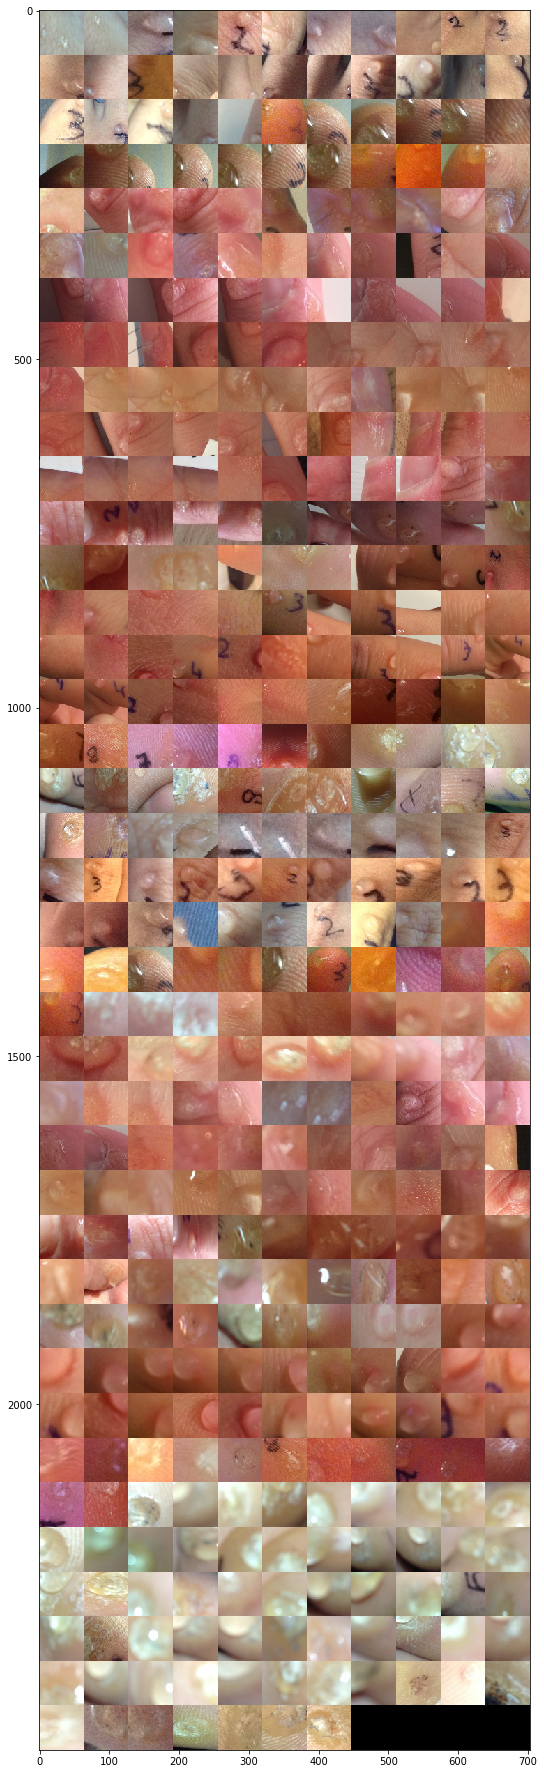

In [15]:
fig = plt.figure(figsize=(32, 32)) 
tstimages = (hists_test[false_neg] + 0.5) * 255.0
for i in range(len(false_neg)):
    tstimages[i] = cv2.cvtColor(tstimages[i].astype(np.float32), cv2.COLOR_BGR2RGB)
plt.imshow(ia.draw_grid(tstimages, cols=9, rows=39))

---
# Visualizing weights

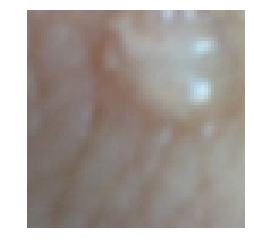

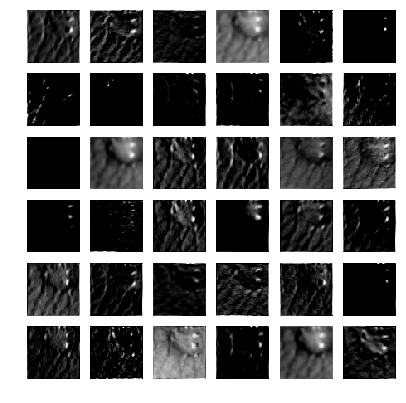

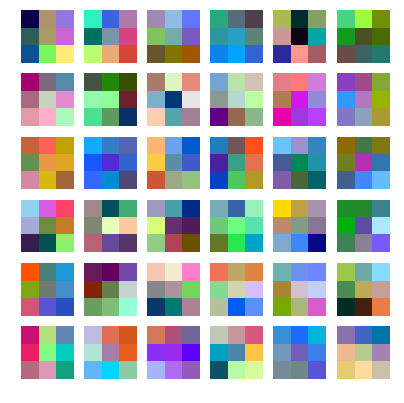

In [145]:
plt.figure()
index = true_pos[1]

weights, activations = sess.run([W1, Y1], feed_dict={X:hists_test[index:index+2], tst: True, tst_conv: True})


img = (hists_test[index]+0.5)*255
img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB).astype(np.uint8)
plt.axis('off')
plt.imshow(img)

# activations
activations = activations[0]
_, sub = plt.subplots(6, 6, figsize=(64, 64))
plt.subplots_adjust(right = 0.23, left=0.15, top=0.18, bottom=0.1)
for i in range(6):
    for j in range(6):
        sub[i, j].axis('off')
        sub[i, j].imshow(activations[:,:,i*6 + j]*255, cmap='gray')
        
# weights
_, sub = plt.subplots(6, 6, figsize=(64, 64))
plt.subplots_adjust(right = 0.23, left=0.15, top=0.18, bottom=0.1)
for i in range(6):
    for j in range(6):
        sub[i, j].axis('off')
        w = weights[:,:,:,i*6 + j]
        w = (w - np.max(w))/-np.ptp(w)
        sub[i, j].imshow(w)

---
# Making heatmap of example image

Visualizing and Understanding Convolutional Networks
Matthew D. Zeiler and Rob Fergus, 2013
https://arxiv.org/abs/1311.2901

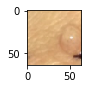

In [130]:
plt.figure(figsize=(1, 1)) 
pos_image_norm = hists_test[true_pos][5]
pos_image = (pos_image_norm + 0.5) * 255.
pos_image = cv2.cvtColor(pos_image.astype(np.float32), cv2.COLOR_BGR2RGB).astype(np.uint8)
plt.imshow(pos_image)

**Utility functions for making a heatmap**
- *block_regions_image*: Blocks off part of the images with a block of a certain size and defined stepsize.
- *heatmap_regions_image*: Makes a heatmap for the predictions generated by testing the blocked images.
- *generate_heatmap*: Combines the above two methods in one method

In [17]:
def block_regions_image(img, size, grayscale, step_size):
    images = []
    steps = np.ceil((img.shape[0] + size[0]) / float(step_size)).astype(int) + 1
    for y in range(steps):
        for x in range(steps):
            blocked_image = np.copy(img)
            if step_size*y <= 0 or step_size*x <= 0 or \
                step_size*y-size[0] >= img.shape[0] or \
                step_size*x-size[1] >= img.shape[1]: 
                continue
            blocked_image[np.max((0,step_size*y-size[0])):step_size*y, \
                          np.max((0,step_size*x-size[1])):step_size*x] = grayscale
            images.append(blocked_image)
    return images

def heatmap_regions_image(image_size, predictions, size, step_size):
    new_image = np.zeros(image_size[0:2])
    steps = np.ceil((image_size[0] + size[0]) / float(step_size)).astype(int) + 1
    i = 0
    for y in range(steps):
        for x in range(steps):
            if step_size*y <= 0 or step_size*x <= 0 or \
                step_size*y-size[0] >= image_size[0] or \
                step_size*x-size[1] >= image_size[1]: 
                    continue
            if predictions[i] > 0.5:
                new_image[np.max((0,step_size*y-size[0])):step_size*y, \
                          np.max((0,step_size*x-size[1])):step_size*x] += predictions[i]
            i += 1
    new_image[np.where(new_image) < 0] = 0
    if np.amax(new_image) == 0:
        # whole img is important
        new_image = np.ones(image_size[0:2])
    return new_image / np.amax(new_image)

def generate_heatmap(norm_img, size, step):
    blocked_imgs = block_regions_image(norm_img, size, -0.5, step)
    blocked_pred = sess.run([Y], feed_dict={X:blocked_imgs ,tst: True, tst_conv: True})[0]
    heatmap = heatmap_regions_image(norm_img.shape, blocked_pred[:,1], size, step)
    return heatmap

**Testing the blocking off method**

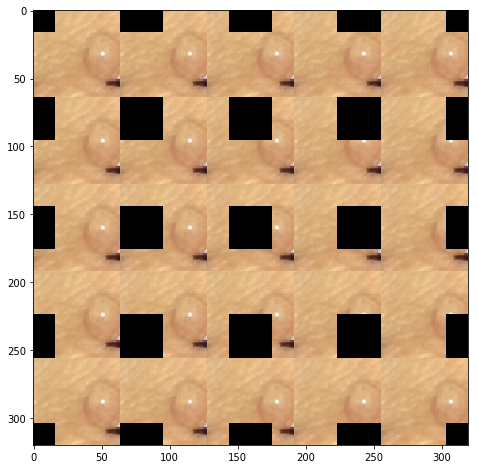

In [20]:
fig = plt.figure(figsize=(8, 8)) 
blocked_imgs_norm = block_regions_image(pos_image_norm, 
                                   size=(32,32), grayscale=-0.5, step_size=16)
blocked_imgs = (np.array(blocked_imgs_norm) + 0.5) * 255
for i in range(len(blocked_imgs)):
    blocked_imgs[i] = cv2.cvtColor(blocked_imgs[i].astype(np.float32), cv2.COLOR_BGR2RGB)
plt.imshow(ia.draw_grid(blocked_imgs[0:100], cols=5, rows=5))

Making predictions based on the blocked off images

In [21]:
blocked_pred = sess.run([Y], feed_dict={X:blocked_imgs_norm, tst: True, tst_conv: True})[0]

This cell shows the blocked off images that were predicted as negative.

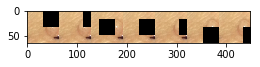

In [22]:
fig = plt.figure(figsize=(32, 32)) 

negs = np.array(blocked_imgs)[np.where(np.argmax(blocked_pred, axis = 1) == 1)]
if len(negs) > 0:
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(ia.draw_grid(negs, cols=1, rows=1))

This function combines all of the above by providing it images it will generate blocked off versions and run the model on them. It will then create heatmaps and combine them with the original images

In [23]:
def make_heatmaps(images, contour=False):
    num_heatmaps = len(images)

    _, sub = plt.subplots(3, num_heatmaps, figsize=(64, 64))
    cmap = plt.get_cmap('hot')
    plt.subplots_adjust(right = 0.40, left=0.15, top=0.18, bottom=0.1)

    heatmaps = []
    for r in range(num_heatmaps):
        heatmap = generate_heatmap(images[r], size=(16,16), step=4)
        heatmaps.append(heatmap)
        heatmap = heatmaps[r]
        
        if contour:
            heatmap_thres = (heatmap > 0)
            edges = np.zeros(heatmap_thres.shape)
            _, contours, _ = cv2.findContours(heatmap_thres.astype(np.uint8), 
                                              cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(edges, contours, -1, 1, thickness=2)
            
        heatmap_color = cmap(heatmap)
        heatmap_color = np.delete(heatmap_color, 3, 2)
        heatmap_color[np.where(heatmap_color==0)] = 0.5
        sub[1, r].axis('off')
        sub[1, r].imshow(heatmap_color)

        img_norm = images[r]
        img = (img_norm + 0.5) * 255.
        img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB).astype(np.uint8)
        sub[0, r].axis('off')
        sub[0, r].imshow(img)
        
        sub[2, r].axis('off')
        if contour:
            img[np.where(edges == 1)] = img.astype(np.float32)[np.where(edges == 1)] * 0.65
            sub[2, r].imshow(img)
        else:
            img_heat = (img * heatmap_color).astype(np.uint8)
            sub[2, r].imshow(img_heat)
            
def img_heatmap(image, size=(16,16), step=4, color=0.2):
    heatmap = generate_heatmap(image, size, step)
    heatmap_thres = (heatmap > 0)
    edges = np.zeros(heatmap_thres.shape)
    _, contours, _ = cv2.findContours(heatmap_thres.astype(np.uint8), 
                                      cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(edges, contours, -1, 1, thickness=2)
    img_new = (image + 0.5) * 255.
    img_new = cv2.cvtColor(img_new.astype(np.float32), cv2.COLOR_BGR2RGB).astype(np.uint8)
    img_new[np.where(edges == 1)] = img_new.astype(np.float32)[np.where(edges == 1)] * color
    return img_new

---
**Resulting heatmaps**

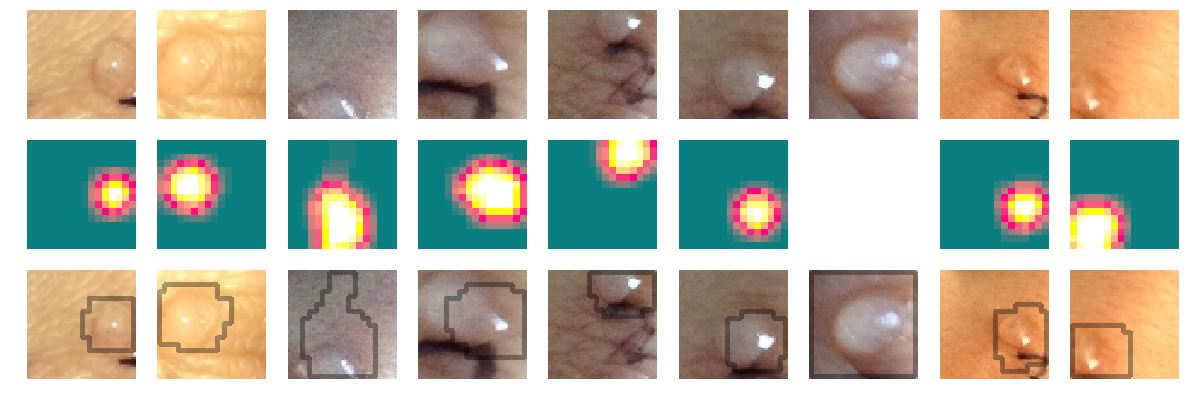

In [24]:
make_heatmaps(hists_test[true_pos][5:14], contour=True)

**False positives**

Heatmap shows parts of the images that can be blocked for the prediction to go to negative instead of positive.

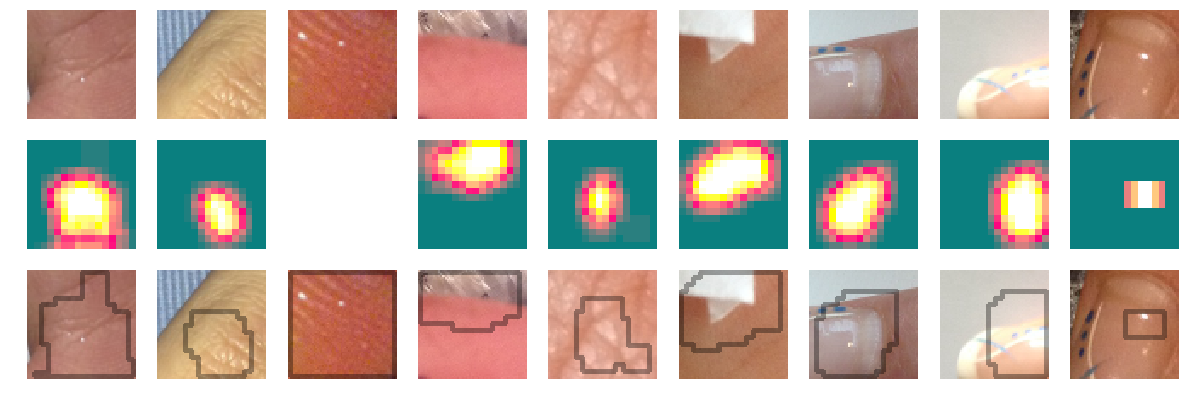

In [25]:
make_heatmaps(hists_test[false_pos][0:9], contour=True)

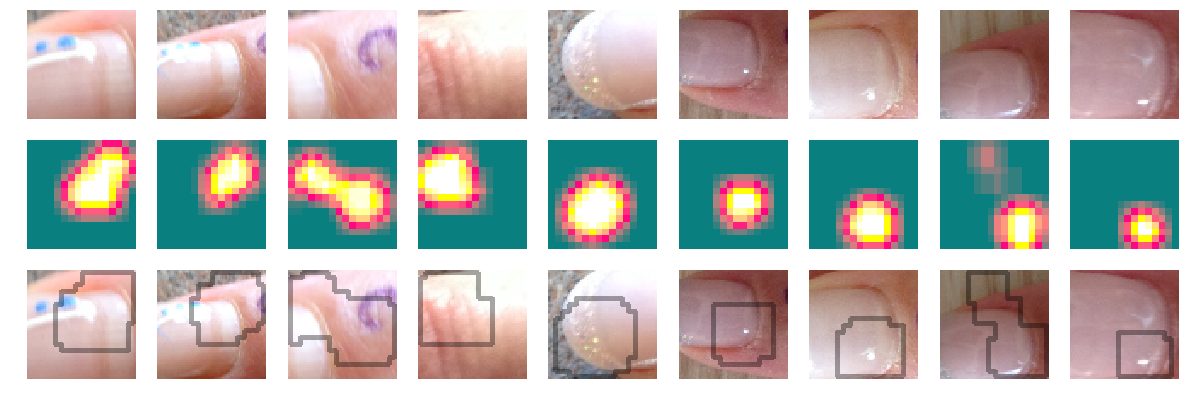

In [26]:
make_heatmaps(hists_test[false_pos][9:18], contour=True)

---
# T-sne

We are gonna run the whole dataset in the network and gather the activations of the activations of the last fully connected layer.

In [27]:
hists_test = np.load("hists_test.npy")
labels_test = np.load("labels_test.npy")
hists_train = np.load("hists_train.npy")
hists_train = (hists_train / 255.) - 0.5
labels_train = np.load("labels_train.npy")

In [28]:
all_data_imgs = np.concatenate((hists_train, hists_test))
all_data_labels = np.concatenate((labels_train, labels_test))

In [29]:
# Run on the test in batches, the network is so large that there is not enough
# memory for all the test data at once
batch_size = 32

activations_all_data = []
pred_labels_all_data = []
number_of_runs = np.ceil(len(all_data_imgs) / batch_size) + 1
for i in range(number_of_runs.astype(int)):
    batch_begin = int(i*batch_size)
    batch_end = int(np.min((i*batch_size+batch_size, len(all_data_imgs))))

    batch_X = all_data_imgs[batch_begin:batch_end]
    all_pred, act_Y6 = sess.run([Y, Y6], feed_dict={X: batch_X, tst: True, iter: i, tst_conv: True})
    activations_all_data += [act_Y6]
    pred_labels_all_data += [all_pred]

pred_labels_all_data = np.concatenate(pred_labels_all_data)
activations_all_data = np.concatenate(activations_all_data)

841.0


In [30]:
np.save("activations_all_data", activations_all_data)

In [31]:
# from bhtsne import run_bh_tsne
# features_TSNE = run_bh_tsne(activations_all_data, 
#                            verbose=True, 
#                            perplexity=45,
#                            max_iter=5000)

# somehow this only works when interrupting the kernel first. 
# This has probably something to do with os.fork
# see terminal for output of bhtsne

features_TSNE = np.load("features_TSNE.npy")

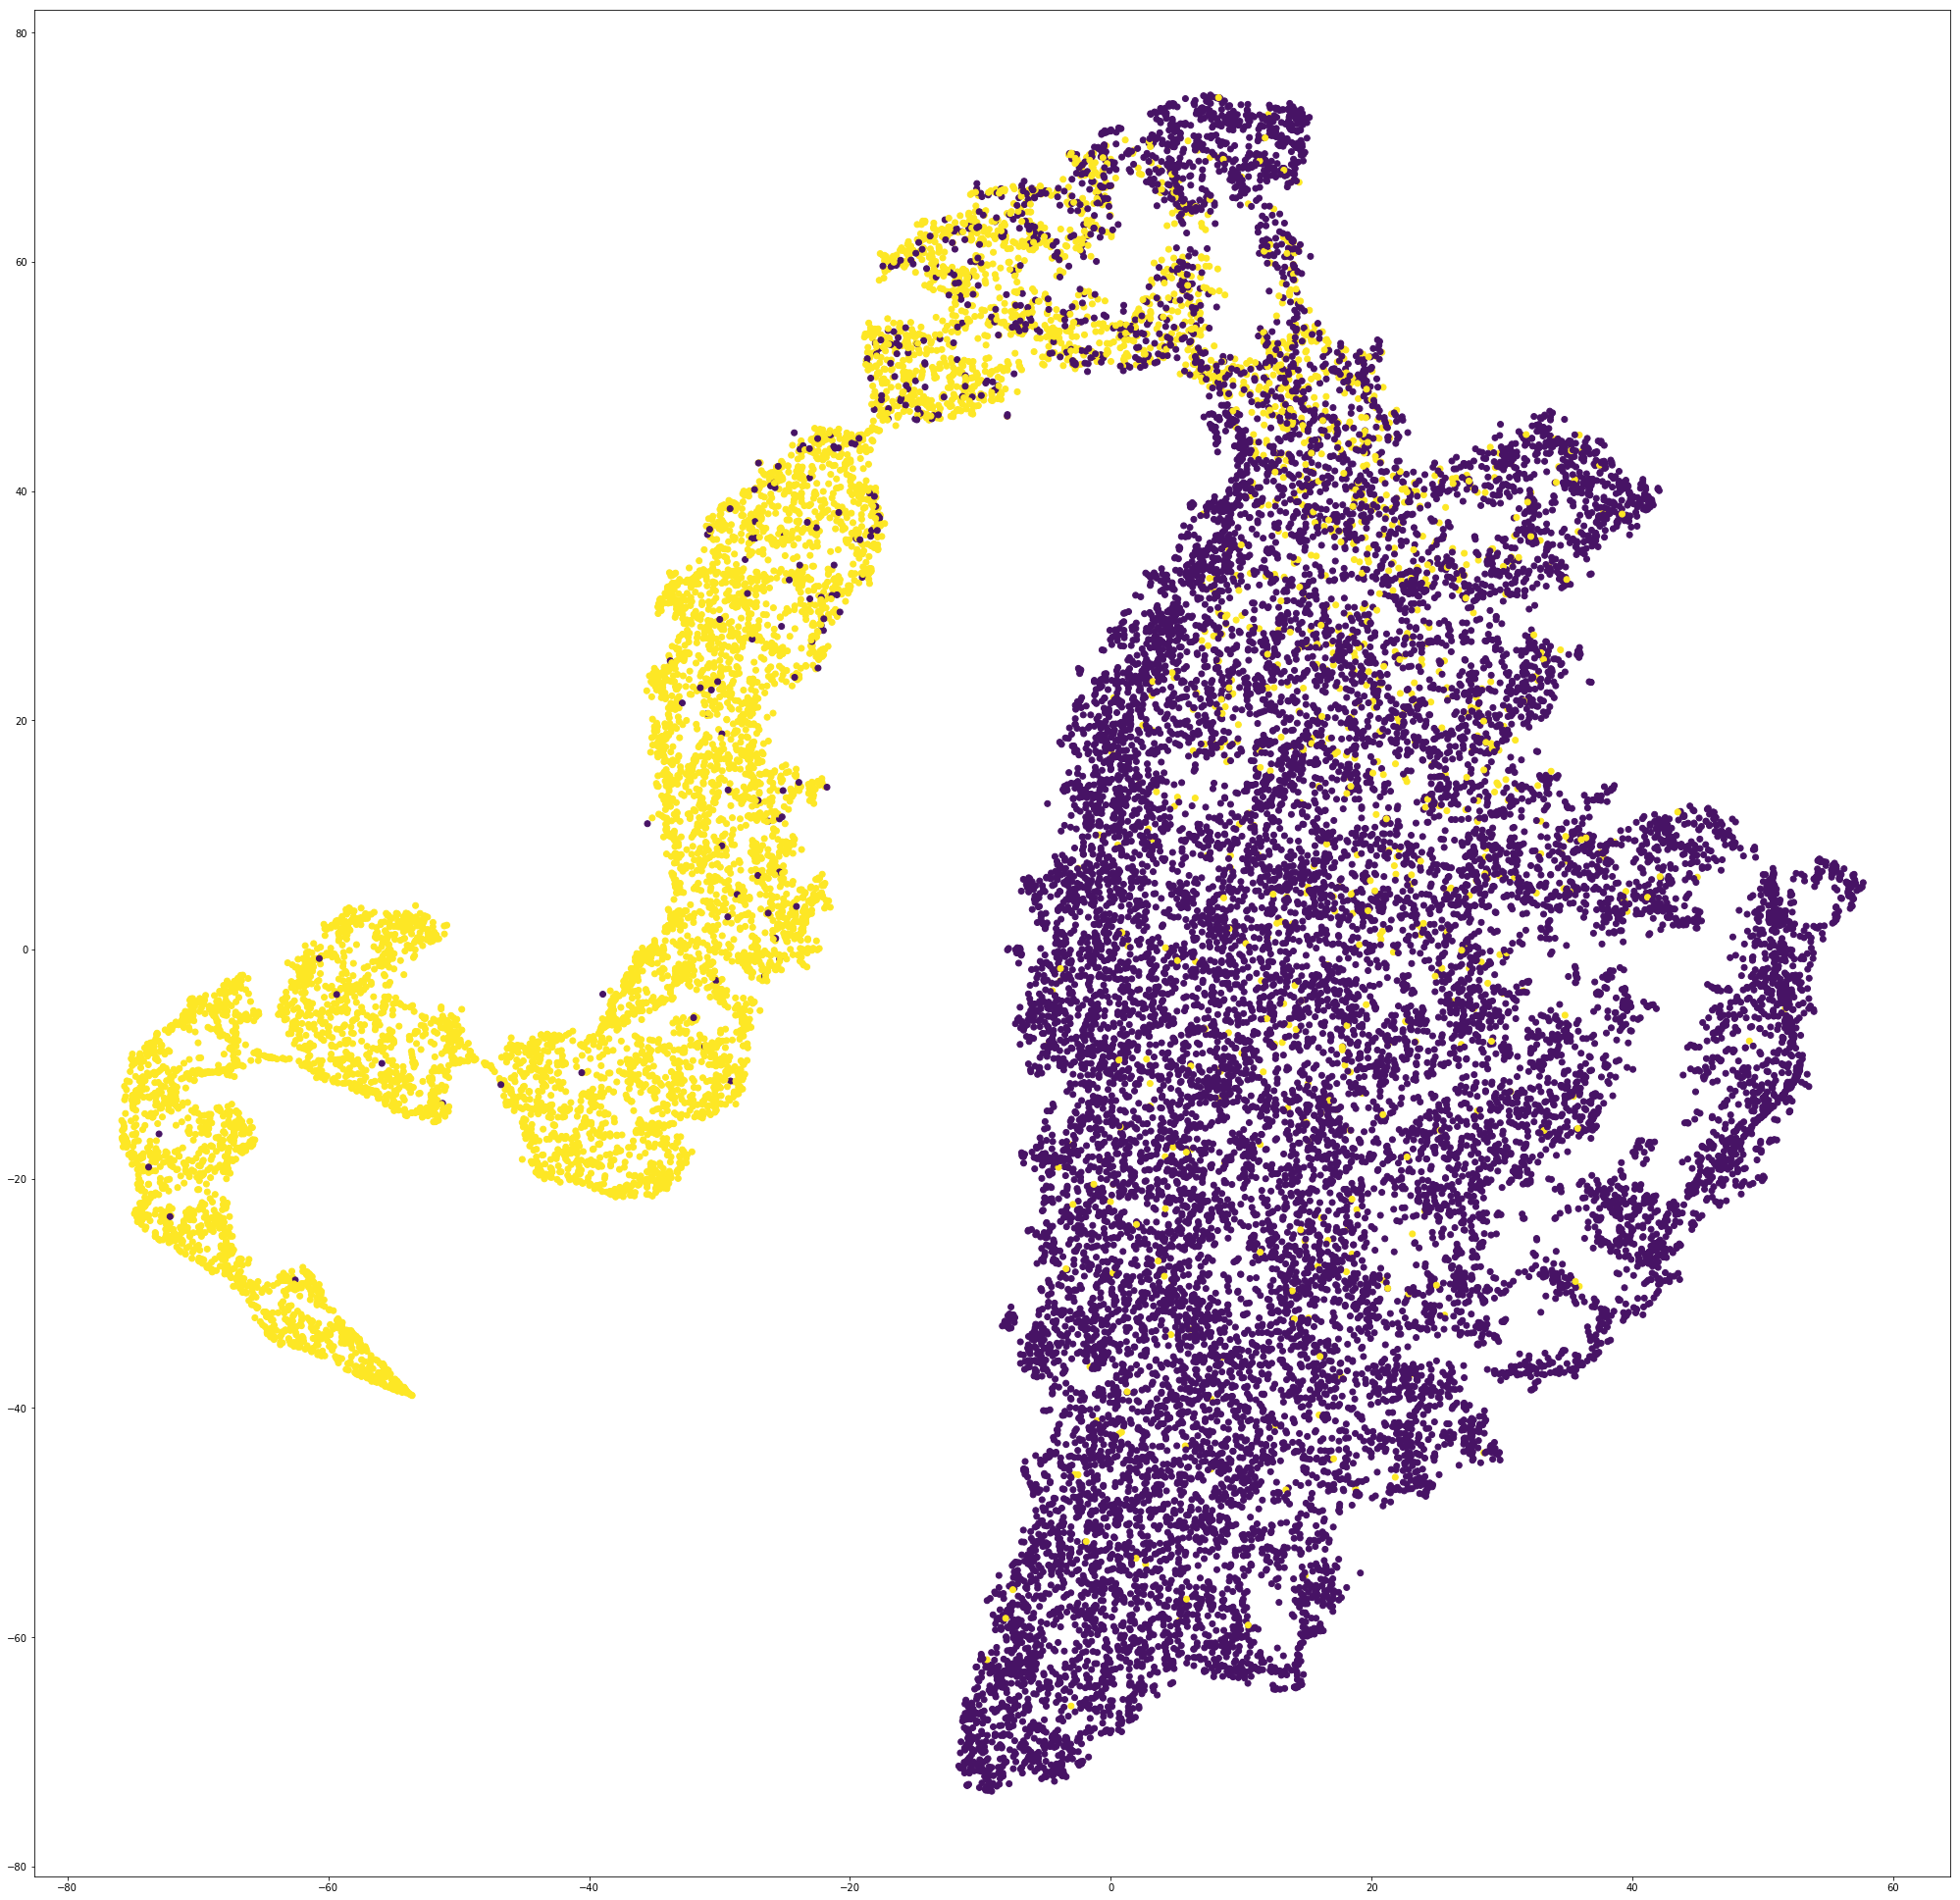

In [32]:
plt.clf()
plt.scatter(features_TSNE[:, 0], features_TSNE[:, 1], 
            c=all_data_labels[:,0]*255, 
            cmap="viridis")
plt.clim(-0.5, 9.5)
figure = plt.gcf()  # get current figure
figure.set_size_inches(35, 35)
plt.show()

In [33]:
# np.save("tsne", features_TSNE)
features_TSNE[0:10]

array([[  8.0579857 ,  51.03364483],
       [ 12.804704  ,  42.85972955],
       [ 13.22574481,  45.50833349],
       [  6.08947726,  52.78457906],
       [ -1.04930717, -41.11195674],
       [-33.09891135,  19.88257016],
       [-28.3316567 ,   4.7525161 ],
       [-12.21814228,  49.42063741],
       [-31.63842612,  -8.17602553],
       [-51.76738659, -15.0193955 ]])

In [34]:
# %autoreload
# all_data_imgs = (all_data_imgs + 0.5) * 255
# cv2.imwrite("tsne_test.png", img)
all_data_imgs_rgb = all_data_imgs.copy()
for i in range(len(all_data_imgs)):
    if pred_labels_all_data[:,0][i] > 0.5:
        img = img_heatmap(all_data_imgs[i], color=0.5)
    else:
        img = all_data_imgs[i]
        img = (img + 0.5) * 255
        img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    all_data_imgs_rgb[i] = img
    if i % 1000 == 0:
        print str(i) + "/" + str(len(all_data_imgs))
    
plt.imshow(all_data_imgs_rgb[50].astype(np.uint8))

0/26885


KeyboardInterrupt: 

In [ ]:
# create a border around images for labelling in scatter plot
from matplotlib import cm

all_data_imgs_rgb_borders = all_data_imgs_rgb.copy()
for i, image in enumerate(all_data_imgs_rgb):
    image = min_resize(image, 64 - 5 * 2)
    image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=(255,255,255))

    b = 5 - 1
    color = None
    color_pred = None
    if all_data_labels[:,0][i] == 1:
        color = np.array(cm.viridis(255)[0:3]) * 255
    else:
        color = np.array(cm.viridis(0)[0:3]) * 255
    
    if pred_labels_all_data[:,0][i] > 0.5:
        color_pred = np.array(cm.viridis(255)[0:3]) * 255
    else:
        color_pred = np.array(cm.viridis(0)[0:3]) * 255
    print color
    all_data_imgs_rgb_borders[i] = cv2.copyMakeBorder(image, b, b, b, b, 
                                                      cv2.BORDER_CONSTANT, 
                                                      value=color) 
    if i < len(hists_train):
        all_data_imgs_rgb_borders[i] = cv2.rectangle(all_data_imgs_rgb_borders[i], 
                                              (7, 56), (14, 49), color_pred, 2, 4)
    else:
        all_data_imgs_rgb_borders[i] = cv2.rectangle(all_data_imgs_rgb_borders[i], 
                                              (6, 57), (15, 48), color_pred, -1)
    

all_data_imgs_rgb_borders = all_data_imgs_rgb_borders.astype(np.uint8)

In [ ]:
plt.imshow(all_data_imgs_rgb_borders[5])
print pred_labels_all_data[:,0][i]
# plt.imshow(all_data_imgs_rgb_borders[0])

In [ ]:
img = image_scatter(features_TSNE, all_data_imgs_rgb_borders, 
                    scatter_size=21000, 
                    img_size=64)
# plt.figure(figsize=(64,64)) 
# plt.imshow(img.astype(np.uint8))

In [ ]:
img2 = cv2.cvtColor(img.astype(np.float32), 
                        cv2.COLOR_BGR2RGB)
cv2.imwrite("tsne_test6.png", img2.astype(np.uint8))
